In [ ]:
!pip install ISLP

In [3]:
# Imports we've used before
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
summarize)

#New imports needed for this lab
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
(LinearDiscriminantAnalysis as LDA,
QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Logistic regression does not converge under separation of the data, as shown in below coding:

That is, when the data points for the two categories are significantly far from each other, the logistic regression line does not converge during the training process.

In this case, the data points for the two categories (0s and 1s) are so far apart that the logistic regression algorithm cannot find a set of parameters that lead to meaningful fit. This is precisely the issue of perfect separation.

Note the warning message.

In [4]:
y0=np.zeros(10)
y1=np.ones(10)
y = np.concatenate((y0, y1))
x0=np.random.normal(0, 1, 10) # this follows Normal(0,1)
x1=np.random.normal(5, 1, 10) # this follows Normal(5,1) to set x0 and x1 far from each other
x = np.concatenate((x0 , x1 ))
df = pd.DataFrame({'x': x})
design = MS(df)
X = design.fit_transform(df)
glm = sm.GLM(y, #Fit logistic regression
X,
family=sm.families.Binomial())
results = glm.fit()
#summarize(results)

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   20
Model:                            GLM   Df Residuals:                       18
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.1110e-09
Date:                Fri, 04 Oct 2024   Deviance:                   4.2221e-09
Time:                        22:30:38   Pearson chi2:                 2.11e-09
No. Iterations:                    23   Pseudo R-squ. (CS):             0.7500
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -47.0923   3.27e+04     -0.001      0.9

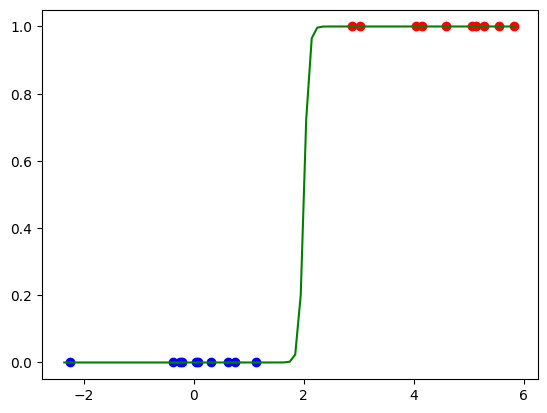

In [5]:
# Plot x0 and y0 with blue points
plt.scatter(x0, y0, color='blue', label='x0, y0', zorder=5)
# Plot x1 and y1 with red points
plt.scatter(x1, y1, color='red', label='x1, y1', zorder=5)
# Generate sequence for smooth curve
seq = pd.DataFrame({'x': np.arange(min(x) - 0.1, max(x) + 0.1, 0.1)})
sequence = design.transform(seq)
prediction_line=results.predict(sequence)

plt.plot(seq, prediction_line, color='green', label='Prediction', zorder=10)
# Show model summary
print(results.summary())

## 4.7 Lab: Logistic Regression

In this lab we will examine the Smarket data, which is part of the ISLP
library. This data set consists of percentage returns for the S&P 500 stock
index over 1,250 days, from the beginning of 2001 until the end of 2005.


For each date, we have recorded the percentage returns for each of the fve
previous trading days, Lag1 through Lag5. We have also recorded Volume
(the number of shares traded on the previous day, in billions), Today (the
percentage return on the date in question) and Direction (whether the
market was Up or Down on this date).
We start by importing our libraries.

Now we load the data and check the available variables

In [ ]:
Smarket = load_data('Smarket')
Smarket.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

In [ ]:
Smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


As one would expect, the correlations between the lagged return variables
and today's return are close to zero. The only substantial correlation is
between `Year` and `Volume`.

In [ ]:
#To show correlations
Smarket.drop(columns='Direction').corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


By plotting the data we see that Volume is increasing over time. In other words, the average number of shares traded daily increased from 2001 to 2005.

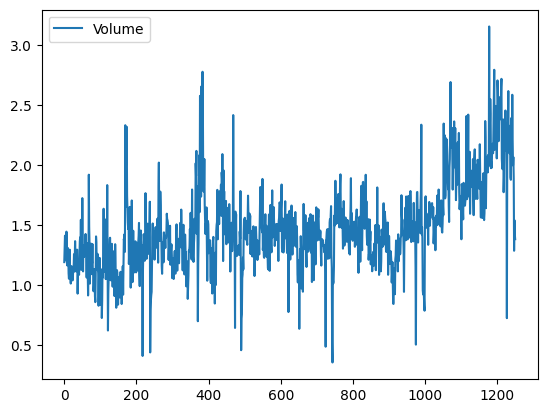

In [ ]:
Smarket.plot(y='Volume');

Next, we will ft a logistic regression model in order to predict Direction
using Lag1 through Lag5 and Volume. The `sm.GLM()` function fits generalized linear models, a class of models that includes logistic regression. The syntax of `sm.GLM()` is similar to that of `sm.OLS()`, except that
we must pass in the argument `family=sm.families.Binomial()` in order to
tell `statsmodels` to run a logistic regression rather than some other type of
generalized linear model.

In [ ]:
allvars = Smarket.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(Smarket)
y = Smarket.Direction == 'Up'
glm = sm.GLM(y,
X,
family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


The smallest p-value here is associated with `Lag1`. The negative coefcient
for this predictor suggests that if the market had a positive return yesterday,
then it is less likely to go up today. However, at a value of 0.15, the p-value
is still relatively large, and so there is no clear evidence of a real association
between `Lag1` and `Direction`.

In [ ]:
 #We access the coefficients for this model
 results.params

,0
intercept,-0.126000
Lag1,-0.073074
Lag2,-0.042301
Lag3,0.011085
Lag4,0.009359
Lag5,0.010313
Volume,0.135441


The `predict()` method of results can be used to predict the probability
that the market will go up, given values of the predictors. This method
returns predictions on the probability scale. If no data set is supplied to
the `predict()` function, then the probabilities are computed for the training data that was used to ft the logistic regression model.

In [ ]:
probs = results.predict()
probs[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In order to make a prediction as to whether the market will go up or
down on a particular day, we must convert these predicted probabilities
into class labels, `Up` or `Down`.

 The following two commands create a vector of class predictions based on whether the predicted probability of a market increase is greater than or less than 0.5.

 Then the `confusion_table()` function from the ISLP package summarizes these predicitions, showing how many observations were correctly or incorrectly classified.

In [ ]:
labels = np.array(['Down']*1250)
labels[probs >0.5] = "Up"

confusion_table(labels, Smarket.Direction)

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


The diagonal elements of the confusion matrix indicate correct predictions,
while the of-diagonals represent incorrect predictions.

 The `np.mean()` function can be used to compute the fraction of
days for which the prediction was correct. In this case, logistic regression
correctly predicted the movement of the market 52.2% of the time.

In [ ]:
 (507+145)/1250, np.mean(labels == Smarket.Direction)

(0.5216, 0.5216)

At frst glance, it appears that the logistic regression model is working
a little better than random guessing. However, this result is misleading
 because we trained and tested the model on the same set of observations. In other words, 100- 52.2 = 47.8% is the *training error rate*.

 In order to better assess the accuracy of the logistic regression model in this setting, we can ft the model using part of the data, and then examine how well it predicts more recent data.

 To implement this strategy, we frst create a Boolean vector corresponding to the observations from 2001 through 2004. We then use this vector to create a held out data set of observations from 2005.

In [ ]:
train = (Smarket.Year < 2005)
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]
#Size of train and test sets
Smarket_test.shape,Smarket_train.shape

((252, 9), (998, 9))

We now ft a logistic regression model using only the subset of the observations that correspond to dates before 2005. We then obtain predicted probabilities of the stock market going up for each of the days in our test set — that is, for the days in 2005

In [ ]:
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
X_train,
family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

Finally, we compare the predictions for 2005 to the actual movements of
the market over that time period.

In [ ]:
D = Smarket.Direction #Substract the directions
L_train, L_test = D.loc[train], D.loc[~train]
labels = np.array(['Down']*252)
labels[probs >0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


The test accuracy is about 48% while the error rate is about 52%

This is even worse than random guessing....

In [ ]:
np.mean(labels == L_test), np.mean(labels != L_test)

(0.4801587301587302, 0.5198412698412699)

We recall that the logistic regression model had very underwhelming p-values associated with all of the predictors, and that the smallest p-value,
though not very small, corresponded to `Lag1`.

Perhaps by removing the variables that appear not to be helpful in predicting Direction, we can obtain a more efective model. After all, using predictors that have no relationship with the response tends to cause a deterioration in the test error rate (since such predictors cause an increase in variance without a corresponding decrease in bias), and so removing such predictors may in turn yield an improvement.

Below we refit the logistic regression using just `Lag1` and `Lag2`, which seemed to have the highest predictive power in the original logistic regression model.

In [ ]:
 model = MS(['Lag1', 'Lag2']).fit(Smarket)
X = model.transform(Smarket)
X_train, X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train,
X_train,
family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
labels = np.array(['Down']*252)
labels[probs >0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


Let's evaluate the overall accuracy as well as the accuracy within the
days when logistic regression predicts an increase.

In [ ]:
(35+106)/252,106/(106+76)

(0.5595238095238095, 0.5824175824175825)

a bit better now 56% of the daily movements have been correcly predicted. Note that there were 141 times were the market went up. So if instead of our model we use a naive model that always predict the market will increase will also be correct 56% of the time.

In [ ]:
141/252

0.5595238095238095